# Quantum modeling with a scattering matrix

Basically the same thing as calculated in basic quantum mechanics courses: 

## Quantum coherent scattering

Simply a linear circuit element (two-port network): takes inputs from the left and from the right (incoming wave amplitudes) and outputs outgoing wave amplitudes to the left and to the right.

It can be described as a unitary matrix `[[left-left reflection, right-left transmission], [left-right transmission, right-right reflection]]`  whose eigenvalues are transmission coefficients. Note that this is `2Nx2N`, each of the entries is an `NxN` block.

We take an unitary **random** matrix and treat is as our scattering matrix.
The distribution of transmission coefficients of is

$$P(T) = \frac{1}{\pi} \sqrt{T(1-T)}$$

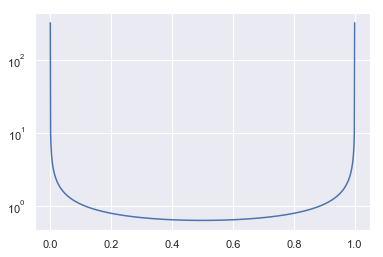

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
T = np.linspace(1e-6, 1-1e-6, 1000)
def Dorokhov_formula(T):
    return 1/np.sqrt(T*(1-T))/np.pi
plt.semilogy(T, Dorokhov_formula(T));

### Conductance quantum



### [Landauer-Buttiker formula](https://en.wikipedia.org/wiki/Landauer_formula)

### [Universal Conductance Fluctuations (UCF)](https://en.wikipedia.org/wiki/Universal_conductance_fluctuations)

### Spectral rigidity

Transmission eigenvalues are correlated - there's a mechanism that relates them!

This can be calculated!

We usually calculate $G / G_0$ ($G_0$ being the conductance quantum $2 e^2 / h$).

### Geometric Jacobian factor introduces correlation between eigenvalues

Gaussian ensembles lead to **hermitian** matrices - **circular ensembles** lead to **unitary** matrices

Current needs to be conserved, what comes in comes out, so $S^\dagger S = 1$.

We know analytical results for the average and variance for CUE (sum of eigenvalues?) - though they're derived for the large number of modes limit.

# Lab

Numerical Scheme via [Francesco Mezzardo arXiv](https://arxiv.org/abs/math-ph/0609050)

In [2]:
import numpy_html

In [3]:
def CUE(N):
    X = np.random.normal(size=(2*N, 2*N))
    Y = np.random.normal(size=(2*N, 2*N))
    Z = (X + 1j * Y)/2**0.5
    Q, R = np.linalg.qr(Z)
    Lambda = np.diag(np.diag(R) / np.abs(np.diag(R)))
    s = Q @ Lambda
    return s

def COE(N):
    m = CUE(N)
    return m.T @ m


wigner_surmise = {
    COE: lambda s: np.pi / 2 * s * np.exp(-np.pi / 4 * s ** 2),
    CUE: lambda s: 32 / np.pi**2 * s**2 * np.exp(-4/np.pi * s**2)
}

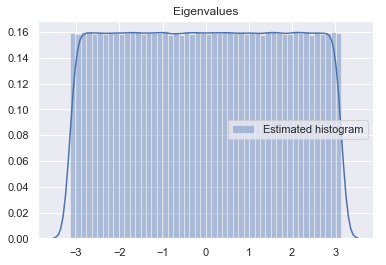

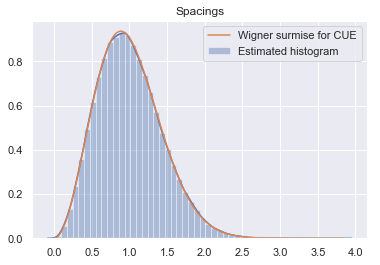

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
sns.set(color_codes=True)

def statistics(n_samples, N, ensemble=CUE, SPACINGS = True):
    all_eigenvalues = []
    if SPACINGS:
        all_spacings = []
    for i in tqdm.tnrange(n_samples):
        matrix = ensemble(N)
        eigenvalues = np.linalg.eigvals(matrix)

        eigenvalues = np.angle(eigenvalues) # CALCULATE EIGENPHASES
        all_eigenvalues.extend(eigenvalues)
        eigenvalues = np.sort(eigenvalues)
        if SPACINGS:
            if N < 10:
                eigenvalues = eigenvalues[eigenvalues.size//2-1:eigenvalues.size//2+1]
            else:
                eigenvalues = eigenvalues[eigenvalues.size//4: eigenvalues.size//4 * 3]
            spacings = np.diff(eigenvalues)
            all_spacings.extend(spacings)
    sns.distplot(all_eigenvalues, label="Estimated histogram")
    plt.title("Eigenvalues")
    heights, bins = np.histogram(all_eigenvalues)
    R = np.sqrt(2*N)
#     bin_plot_x = np.linspace(-R, R, 1000)
#     plt.plot(bin_plot_x, semicircle_law(bin_plot_x, R), label="Wigner semicircle law")
    plt.legend(loc='best')
    
    if SPACINGS:
        all_spacings = np.array(all_spacings) / np.mean(all_spacings)
        plt.figure()
        sns.distplot(all_spacings, label="Estimated histogram")
        plt.title("Spacings")
        heights, bins = np.histogram(all_spacings)
        bin_plot_x = np.linspace(bins.min(), bins.max(), 1000)
        plt.plot(bin_plot_x, wigner_surmise[ensemble](bin_plot_x), label=f"Wigner surmise for {ensemble.__name__}")
        plt.legend(loc='best')

statistics(n_samples = 20000, N = 20)

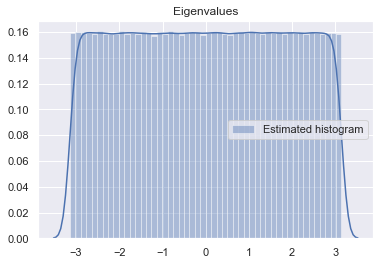

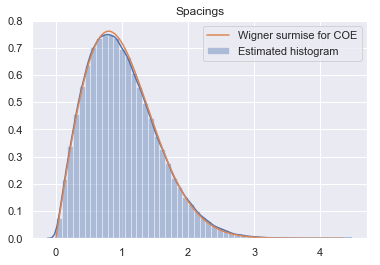

In [12]:
statistics(n_samples = 20000, N = 20, ensemble = COE)

# Task 2


Got <G>: 9.751 as compared to asymptotic analytical value 9.750
Got VarG: 0.125 as compared to asymptotic analytical value 0.125


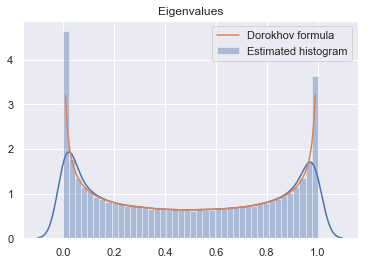

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
sns.set(color_codes=True)

G0 = 1

betas = {COE: 1, CUE:2}

def statistics2(n_samples, N, ensemble=COE):
    all_eigenvalues = []
    Gs = []
    for i in tqdm.tnrange(n_samples):
        matrix = ensemble(N)
        transmission = matrix[N:, :N]
        eigenvalues = np.linalg.eigvalsh(transmission @ np.conj(transmission.T))
        all_eigenvalues.extend(eigenvalues)
        Gs.append(eigenvalues.sum())
    sns.distplot(all_eigenvalues, label="Estimated histogram")
    plt.title("Eigenvalues")
    heights, bins = np.histogram(all_eigenvalues)
    bin_plot_x = np.linspace(0.01, 0.99, 1000)
    plt.plot(bin_plot_x, Dorokhov_formula(bin_plot_x), label="Dorokhov formula")
    plt.legend(loc='best')
    Gmean, Gvar = np.mean(Gs), np.var(Gs)
    beta = betas[ensemble]
    Gmean_analytical = N / 2 + 0.25 * (1 - 2 / beta)
    Gvar_analytical = 1 / (8 * beta)
    print(f"Got <G>: {Gmean:.3f} as compared to asymptotic analytical value {Gmean_analytical:.3f}")
    print(f"Got VarG: {Gvar:.3f} as compared to asymptotic analytical value {Gvar:.3f}")
    
    return all_eigenvalues
#     G = G0 * np.mean(all_eigenvalues)
    
all_eigvals = statistics2(n_samples = 10000, N = 20, ensemble=COE)


Got <G>: 15.001 as compared to asymptotic analytical value 15.000
Got VarG: 0.064 as compared to asymptotic analytical value 0.064


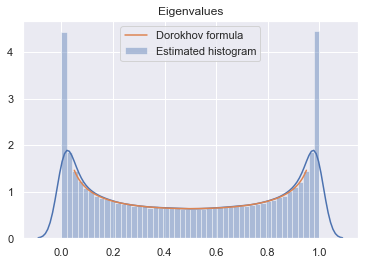

In [64]:
statistics2(n_samples = 10000, N = 30, ensemble=CUE);